In [1]:
import os, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tqdm.auto import tqdm

import transformers
import torch
import torchmetrics
import pytorch_lightning as pl

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = 'klue/roberta-large'

In [3]:
df_train = pd.read_csv('/data/ephemeral/home/level1/data/train.csv')
df_valid = pd.read_csv('/data/ephemeral/home/level1/data/dev.csv')
df_test = pd.read_csv('/data/ephemeral/home/level1/data/test.csv')

In [4]:
def seed_all(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print('SEED VALUE:',seed)

seed_all(42)

SEED VALUE: 42


In [5]:
max(df_train['sentence_1'].str.len()) + max(df_train['sentence_2'].str.len())

212

# 분석

## 라벨 분포 확인

<Axes: >

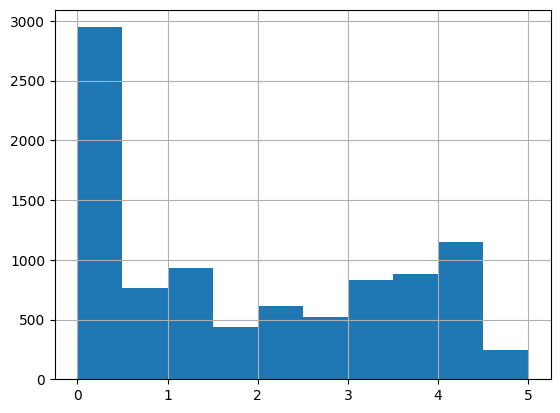

In [6]:
df_train['label'].hist()

In [7]:
df_train['source'].unique()

array(['nsmc-sampled', 'slack-rtt', 'petition-sampled', 'slack-sampled',
       'nsmc-rtt', 'petition-rtt'], dtype=object)

In [8]:
df_train['source'] = df_train['source'].str.extract('(\S+)-(\S+)')[0]

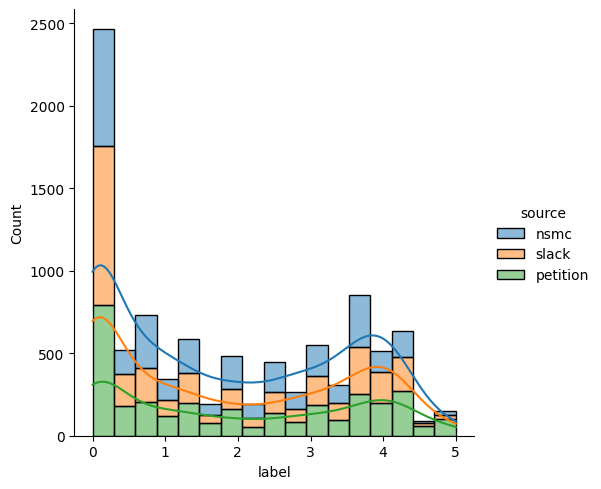

In [9]:
sns.displot(data=df_train, x='label', hue='source', kde=True, multiple="stack")

In [10]:
df_train['source'].value_counts()

source
petition    3169
nsmc        3084
slack       3071
Name: count, dtype: int64

5692


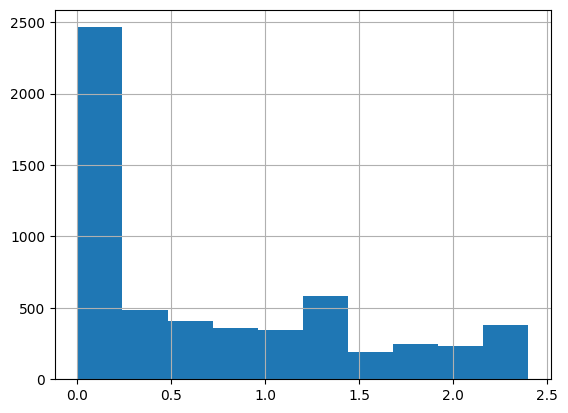

In [11]:
df_train[df_train['binary-label']==0]['label'].hist()
print(df_train[df_train['binary-label']==0].shape[0])

3632


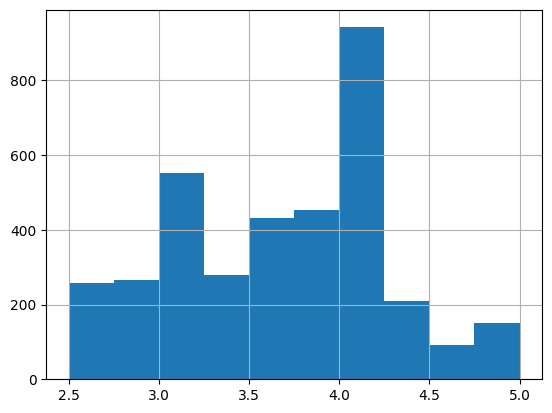

In [12]:
df_train[df_train['binary-label']==1]['label'].hist()
print(df_train[df_train['binary-label']==1]['label'].shape[0])

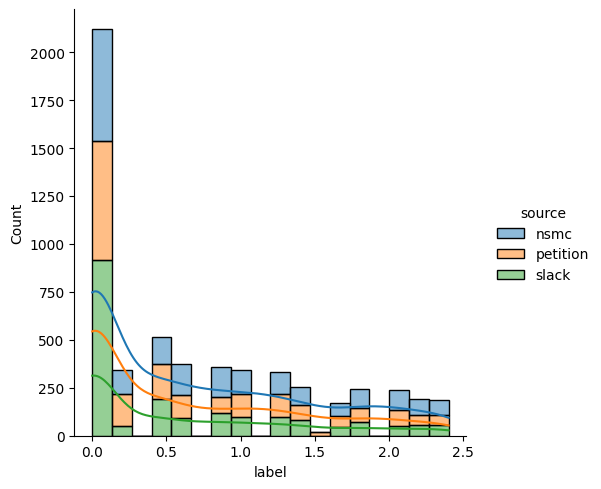

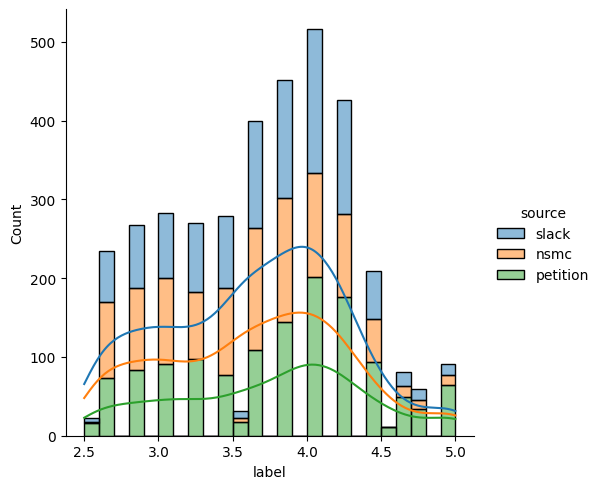

In [13]:
df_b0 = df_train[df_train['binary-label']==0]
df_b1 = df_train[df_train['binary-label']==1]

sns.displot(data=df_b0,x='label',hue='source', kde=True, multiple="stack")
sns.displot(data=df_b1,x='label',hue='source', kde=True, multiple="stack")

plt.show()

### label 반올림

In [14]:
df_train['round-label'] = df_train['label'].apply(np.round)
df_round = df_train['round-label'].value_counts().to_frame().sort_index()
df_round

,count
round-label,
0.0,2981
1.0,1658
2.0,1075
3.0,1334
4.0,2045
5.0,231


In [16]:
df_train['binary-label'].value_counts()

binary-label
0.0    5692
1.0    3632
Name: count, dtype: int64

In [28]:
total = sum(df_round['count'].to_list())
weight = [total/(x*10) for x in df_round['count'].to_list()]
weight

[0.3127809459912781,
 0.5623642943305187,
 0.8673488372093023,
 0.6989505247376312,
 0.4559413202933985,
 4.036363636363636]

In [22]:
df_valid['round-label'] = df_valid['label'].apply(np.round)
df_valid['round-label'].value_counts().to_frame().sort_index()

,count
round-label,
0.0,46
1.0,108
2.0,110
3.0,110
4.0,117
5.0,59


In [24]:
df_test.columns

Index(['id', 'source', 'sentence_1', 'sentence_2'], dtype='object')

## 데이터 확인

In [14]:
source_group = df_train.groupby('source')
df_nsmc = source_group.get_group('nsmc')
df_slack = source_group.get_group('slack')
df_ptt = source_group.get_group('petition')

In [15]:
rand_idxs = np.random.randint(0, len(df_ptt),size=5)
df_ptt.iloc[rand_idxs]

,id,source,sentence_1,sentence_2,label,binary-label
2523,boostcamp-sts-v1-train-2523,petition,한국당 '의원정수 200명으로 줄이자',로스쿨 입학정원 연 1만명으로 늘려야 합니다.,0.0,0.0
3872,boostcamp-sts-v1-train-3872,petition,위헌소지있는 종교인과세 시행전 개정요청.,로또는 이중과세적인 부분도 있네요. 위헌이네요.,0.2,0.0
3378,boostcamp-sts-v1-train-3378,petition,한국 표준시 뒤집지 마세요.,지자체 시의원 수 늘리지 마세요,0.0,0.0
3273,boostcamp-sts-v1-train-3273,petition,가정용 등유도 세금을 낮춰주세요,가정용 등유에 대한 세금 인하,4.0,1.0
9094,boostcamp-sts-v1-train-9094,petition,제발아무것도생각하지마세요,아무 생각도 하지 말아주세요,4.0,1.0


In [16]:
rand_idxs = np.random.randint(0, len(df_slack),size=5)
df_slack.iloc[rand_idxs]

,id,source,sentence_1,sentence_2,label,binary-label
5024,boostcamp-sts-v1-train-5024,slack,크흡 고양이는 언제나 처음엔 호랑이다 생각하고 눈치봐야 ㅋㅋ,항상 처음에는 규숑 고양이가 호랑이인줄 알고 눈치채네요 ㅋㅋ,1.8,0.0
6529,boostcamp-sts-v1-train-6529,slack,중간 난입해주신 <PERSON> 님께 감사인사를 담으며 전 200!!!,아주 fancy 한 식사를 했습니다ㅋㅋㅋ 그리고 pcr 받으시느라 못 오신 ; 깜짝...,0.4,0.0
1465,boostcamp-sts-v1-train-1465,slack,오늘 오시기로 하신 분들은 식당으로 바로 와주시면 될 것 같습니다.,오늘 오실 예정이시면 바로 식당으로 오시기 바랍니다.,4.0,1.0
3764,boostcamp-sts-v1-train-3764,slack,오늘의 결론: 혼자든 둘이든 행복하니 됐다~~!!,오늘의 결론 : 혼자나 둘이서나 행복해져서 행복해~~!!,3.4,1.0
1019,boostcamp-sts-v1-train-1019,slack,이번 주 월요일 <PERSON> 님과 밥스테이지를 진행했습니다!,비오는 한주의 첫날인 월요일 <PERSON> 님과 함께 밥스테이지를 진행했습니다.,3.2,1.0


In [17]:
rand_idxs = np.random.randint(0, len(df_nsmc),size=5)
df_nsmc.iloc[rand_idxs]

,id,source,sentence_1,sentence_2,label,binary-label
4422,boostcamp-sts-v1-train-4422,nsmc,아오이유우때메점줌...,아...나이거보는내내풀로잤음..............,0.0,0.0
6413,boostcamp-sts-v1-train-6413,nsmc,공포영화무서워하는데 진짜연기가어색해서 무서운지몰겠다,공포영화는 무서워하는데 연기가 정말 어색해서 무서운지 모르겠다.,4.2,1.0
8817,boostcamp-sts-v1-train-8817,nsmc,볼만 하고 짱이다...ㅠㅠ,볼만하네요..!!!,3.4,1.0
456,boostcamp-sts-v1-train-456,nsmc,올해 최고 걸작인듯,히어로물중의 최고걸작이라 할수있음.,2.4,0.0
5022,boostcamp-sts-v1-train-5022,nsmc,의미를 찾는 이에게 해갈해줄 영화.,영화를 보고 줄거리를 찾게 만드는 영화.,0.2,0.0


In [18]:
df_train[df_train['label']==5].head()

,id,source,sentence_1,sentence_2,label,binary-label
342,boostcamp-sts-v1-train-342,petition,정형식판사 감사요청,정형식 판사 감사요청,5.0,1.0
358,boostcamp-sts-v1-train-358,petition,이병박 출국금지 청원 합니다.,이명박 출국 금지 청원합니다.,5.0,1.0
448,boostcamp-sts-v1-train-448,petition,제주도 가정용lpg통가스보일러,제주도 가정용 LPG 통가스보일러,5.0,1.0
621,boostcamp-sts-v1-train-621,petition,청소년법 폐지 시켜주세요,청소년법 폐지 시켜 주세요,5.0,1.0
624,boostcamp-sts-v1-train-624,nsmc,"잔잔한 감동으로 다가온영화,","잔잔한 감동으로 다가온 영화,",5.0,1.0


In [19]:
df_train[df_train['label']>=4].head()

,id,source,sentence_1,sentence_2,label,binary-label
1,boostcamp-sts-v1-train-001,slack,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
9,boostcamp-sts-v1-train-009,petition,크림하우스 환불조치해주세요.,크림하우스 환불조치할 수 있도록해주세여,4.2,1.0
18,boostcamp-sts-v1-train-018,petition,정말 간절히 정부의 도움이 필요합니다.,정부의 도움이 절실히 필요합니다.,4.0,1.0
21,boostcamp-sts-v1-train-021,petition,김기덕 조재현 성폭행 철저히 수사해주세요!,김기덕·조재현 성폭행 의혹 철저히 수사하라!,4.2,1.0
24,boostcamp-sts-v1-train-024,nsmc,군대가기전에 봤었는데 진짜 윈터스같은 사람이 상관이면 목숨걸고 싸워도 후회는 없지 ...,입대하기 전에 봤는데 윈터스 같은 사람이 진심으로 아껴준다면 목숨을 걸고 싸워도 후...,4.2,1.0


In [20]:
df_train[(df_train['label']>=3) & (df_train['label']<4)].head()

,id,source,sentence_1,sentence_2,label,binary-label
3,boostcamp-sts-v1-train-003,slack,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
6,boostcamp-sts-v1-train-006,slack,전 암만 찍어도 까만 하늘.. ㅠㅠ,암만 찍어도 하늘은 까맣다.. ㅠㅠ,3.6,1.0
11,boostcamp-sts-v1-train-011,nsmc,극의전개가너무느릿하여답답합니다,전개가 너무 느려서 속터진다,3.8,1.0
12,boostcamp-sts-v1-train-012,nsmc,오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!,오랜만에 존 쿠삭의 연기를 보니 반갑다. 좋아요~~!!,3.8,1.0
16,boostcamp-sts-v1-train-016,slack,환갑이면? ㅎㅎㅎ 이런 재미난 얘기하느라 시간이 금방 가더라고요.,넘넘 즐거운 이야기를 하고나니 시간이 금방 가버렸네요.,3.0,1.0


In [21]:
df_train[(df_train['label']>=2) & (df_train['label']<3)].head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
2,boostcamp-sts-v1-train-002,petition,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
5,boostcamp-sts-v1-train-005,nsmc,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
10,boostcamp-sts-v1-train-010,slack,그 책부터 언능 꺼내봐야 겠어요!,책에서 꺼내야겠어요!,2.4,0.0
39,boostcamp-sts-v1-train-039,petition,휴교령을 내려주세요,대구광역시 휴교령 내려주십시요,2.8,1.0


In [22]:
df_train[(df_train['label']>=1) & (df_train['label']<2)].head()

,id,source,sentence_1,sentence_2,label,binary-label
13,boostcamp-sts-v1-train-013,nsmc,글쎄.. 특색도 없고 별로였던 걸로 기억하는데..,큰 반전 없던걸로 기억하는데...,1.8,0.0
35,boostcamp-sts-v1-train-035,slack,또 먹어 보고 싶네요.,얼마나 드시고 싶었으면…,1.2,0.0
48,boostcamp-sts-v1-train-048,petition,알콜중독자가 기초생활수급자?,기초생활수급자 장애인을 위하여.,1.0,0.0
53,boostcamp-sts-v1-train-053,nsmc,"다만, 관객에 대한 배려가 없다.",이 정도 수준으로 영화관에 내보내는건 관객에 대한 모독이다.,1.8,0.0
56,boostcamp-sts-v1-train-056,nsmc,제일 좋은것같던데..,난이게 제일 재밌었는데..,1.6,0.0


In [23]:
df_train[df_train['label']<1].head()

,id,source,sentence_1,sentence_2,label,binary-label
4,boostcamp-sts-v1-train-004,slack,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
7,boostcamp-sts-v1-train-007,nsmc,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이렇게 지겨운 공포영화는 처음..,0.6,0.0
8,boostcamp-sts-v1-train-008,petition,미세먼지 해결이 가장 시급한 문제입니다!,가장 시급한 것이 신생아실 관리입니다!!!,0.4,0.0
14,boostcamp-sts-v1-train-014,slack,아래는 게임 내에서 함께 팀을 맺고 캡쳐한 이미지입니다.,여러분들간의 다양한 아이디어를 제안하고 나누는 채널입니다.,0.0,0.0
15,boostcamp-sts-v1-train-015,petition,LG전자 스마트폰 생산 중단 청원,LG전자서비스의 노조 와해를 조사해주세요.,0.4,0.0


In [24]:
df_train[df_train['label']==0].head()

,id,source,sentence_1,sentence_2,label,binary-label
4,boostcamp-sts-v1-train-004,slack,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
14,boostcamp-sts-v1-train-014,slack,아래는 게임 내에서 함께 팀을 맺고 캡쳐한 이미지입니다.,여러분들간의 다양한 아이디어를 제안하고 나누는 채널입니다.,0.0,0.0
19,boostcamp-sts-v1-train-019,petition,내년 러시아월드컵 자진포기 청원드립니다.,2023 아시안컵 유치에 공동개최를 반대 합니다.,0.0,0.0
20,boostcamp-sts-v1-train-020,slack,앞머리 새로 하셨습니다. ^^,가방에 넣어 다니면서 조금씩 먹습니다. ^^,0.0,0.0
22,boostcamp-sts-v1-train-022,slack,답답할 때 보면 속이 뻥 뚫릴 것 같아요,양보단 한입 먹는 순간 고삐 풀릴 것 같아요 ㅋㅋㅋ,0.0,0.0


# 모델

In [25]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME, max_length=256)

In [30]:
corpus = []
for item in (df_train['sentence_1'] + ' ' + df_train['sentence_2']):
    corpus.append(item)

In [33]:
sen_with_unk = []
tok_with_unk = []

for sentence in corpus:
    temp = tokenizer.tokenize(sentence, add_special_tokens=True)
    if '[UNK]' in temp:
        tok_with_unk.append(temp)
        sen_with_unk.append(sentence)

In [37]:
len(sen_with_unk)

408

In [35]:
sen_with_unk

['앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.',
 '오마이가뜨지져스크롸이스트휏 오 마이 갓 지저스 스크론 이스트 팬',
 '처음 뵌 분들과 빠르게 친해질 수 있을 것 같은 느낌! 처음 만나는 사람들과 금방 친해질 수 있는 것 같아요!',
 '와아아아안전 좋아요오오 꺄오오올!!!!! 환영합니다아아아',
 '수지 목소리 너무좋아ㅜㅜㅜ 소소한재미ㅜㅋ여탯껏삶을다시돌아보게하는영화ㅜ',
 '이런 저런 회사 이야기 나누다가, 장안의 화제 오징어게임이야기가 나왔는데, 이정재 성대모사 비법도 알려주셨어요. 다음에 뵐 때는 오징어게임 오일남 성대모사를 해주시겠다고 하셔서 기대하고 있겠습니다',
 '나이가 많은 청년들이 살수있게 햐주세요 청년들이 살기좋은 나라로 만들어주십시요.',
 '기대하고 봣는데 기대이하인것아요 기대했는데 기대 이하입니다.',
 '개인적으로 가사가 공감되는 곡입니다..ㅎㅎ 뭔가 새벽 갬성에 맞는 곡 선정입니다...',
 '엇 넵 바로 아시는군요 ..! 아 네 바로 알 수 있습니다..!',
 '퐈이야!! 잘 마치시고 재충전타임 꼭 가지셨으면 좋겠어요~ 👌👌👌👌 좋은 시간 보내시고 재충전의 시간 되시기 바랍니다!',
 'ㅋㅋ물안경 뭔데욬ㅋㅋ 하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하',
 '다시 본 맬 깁슨, 오랜만에 본 괜찮은 가족영화!',
 '의정부 발곡고등학교 등굣길 문제 대성고등학교 사망자 관련 학생안전을 위한 학교 활동',
 '진ㅉ ㅏ심장 너무 아파요… 마음이 너무 아파요...',
 '“공정”한 사회 지금부터라도 선언합시다. ☼문재인정부는 교육을 획기적으로 개혁하라!',
 '국민여러분 한국을지킵시다. 자유 대한민국을 지킵시다.',
 '슬프지만 액션이 너무 부족해서 아쉬움 너무 짦다는게 아쉬움',
 '믕지가 잇어서 내가잇는거임 ㅎㅎㅎ 애가 집중해서 보더라구요 ㅋㅋ',
 '초보 분들은 쭈뼛쭈뼛 하며 요청, 중수는 자연스럽게 요청, 고수는 눈빛으로 요청 초심자는 목이 뻣뻣한 상태로 청원을 

In [7]:
tokenizer.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [8]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [48]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, masks, targets=[]):
        self.inputs = inputs
        self.masks = masks
        self.targets = targets

    # 학습 및 추론 과정에서 데이터를 1개씩 꺼내오는 곳
    def __getitem__(self, idx):
        # 정답이 있다면 else문을, 없다면 if문을 수행합니다
        if len(self.targets) == 0:
            return torch.tensor(self.inputs[idx]), torch.tensor(self.masks[idx])
        else:
            return torch.tensor(self.inputs[idx]), torch.tensor(self.masks[idx]), torch.tensor(self.targets[idx])

    # 입력하는 개수만큼 데이터를 사용합니다
    def __len__(self):
        return len(self.inputs)

In [49]:
def tokenizing(dataframe):
    data, mask = [], []
    for idx, item in tqdm(dataframe.iterrows(), desc='tokenizing', total=len(dataframe)):
        # 두 입력 문장을 [SEP] 토큰으로 이어붙여서 전처리합니다.
        text = ' [SEP] '.join([item[text_column] for text_column in ['sentence_1', 'sentence_2']])
        outputs = tokenizer(text, add_special_tokens=True, padding='max_length', truncation=True, max_length=256)
        data.append(outputs['input_ids'])
        mask.append(outputs['attention_mask'])
    return data, mask

In [50]:
def preprocessing(data):
    # 안쓰는 컬럼을 삭제합니다.
    data = data.drop(columns=['id'])

    # 타겟 데이터가 없으면 빈 배열을 리턴합니다.
    try:
        targets = data[['label']].values.tolist()
    except:
        targets = []
    # 텍스트 데이터를 전처리합니다.
    input_ids, masks = tokenizing(data)

    return input_ids, masks, targets

In [51]:
# 학습 데이터와 검증 데이터셋을 호출합니다
# 학습데이터 준비
train_inputs, train_masks, train_targets = preprocessing(df_train)

# 검증데이터 준비
val_inputs, val_masks, val_targets = preprocessing(df_valid)

# train 데이터만 shuffle을 적용해줍니다, 필요하다면 val, test 데이터에도 shuffle을 적용할 수 있습니다
train_dataset = CustomDataset(train_inputs, train_masks, train_targets)
val_dataset = CustomDataset(val_inputs, val_masks, val_targets)

# 평가데이터 준비
test_inputs, test_masks, test_targets = preprocessing(df_test)
test_dataset = CustomDataset(test_inputs, test_masks, test_targets)

tokenizing: 100%|██████████| 1100/1100 [00:00<00:00, 3528.15it/s]


In [52]:
BATCH_SIZE = 16

train_dataloader=  torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [76]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
            pretrained_model_name_or_path=MODEL_NAME, num_labels=1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32000, 1024, padding_idx=1)

In [70]:
temp_input, temp_mask, temp_target = next(iter(train_dataloader))

In [71]:
temp_input.shape

torch.Size([16, 256])

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [78]:
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)

In [79]:
EPOCHS = 4
best_loss = np.inf
best_acc = 0.0

for epoch in range(1, EPOCHS+1):
    
    print("EPOCH:",epoch)
    train_loss = 0.0
    model.train()
    
    torch.cuda.empty_cache()
    gc.collect()
    
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        batch = [b.to(device) for b in batch]
        input_ids, input_masks, label = batch
        
        outputs = model(input_ids=input_ids, attention_mask=input_masks)['logits']
        loss = criterion(outputs, label.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    print("Train Loss:", train_loss/len(train_dataloader))
    
    print('Validation Mode')
    
    valid_loss, valid_acc = 0.0, 0.0
    model.eval()
    
    torch.cuda.empty_cache()
    gc.collect()
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            batch = [b.to(device) for b in batch]
            input_ids, input_masks, label = batch
        
            outputs = model(input_ids=input_ids, attention_mask=input_masks)['logits']
            loss = criterion(outputs, label.float())
            valid_loss += loss.item()
            valid_acc += torchmetrics.functional.pearson_corrcoef(outputs.squeeze(), label.squeeze()).item()
    
    print("Valid Loss:", valid_loss/len(val_dataloader), 'Valid Acc:', valid_acc/len(val_dataloader))
    
    # if best_loss > valid_loss:
    #     print('SAVE MODEL')
    #     model.save_pretrained('../models/best_roberta')
    #     best_loss = valid_loss
        
    if best_acc < valid_acc:
        print('SAVE MODEL')
        model.save_pretrained('../models/best_roberta')
        best_acc = valid_acc
    print('---------------------')

EPOCH: 1


100%|██████████| 583/583 [06:44<00:00,  1.44it/s]


Train Loss: 2.6673531419826
Validation Mode


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Valid Loss: 2.7379969562802997 Valid Acc: 0.24973669557699135
SAVE MODEL
---------------------
EPOCH: 2


100%|██████████| 583/583 [06:44<00:00,  1.44it/s]


Train Loss: 2.6422201650629322
Validation Mode


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Valid Loss: 2.548192892755781 Valid Acc: 0.18879319611670717
---------------------
EPOCH: 3


 14%|█▍        | 82/583 [00:57<05:51,  1.42it/s]


KeyboardInterrupt: 

In [59]:
model.from_pretrained('../models/best_roberta')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [61]:
preds = []
model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = [b.to(device) for b in batch]
        input_ids, input_masks = batch
    
        outputs = model(input_ids=input_ids, attention_mask=input_masks)['logits']
        outputs = outputs.squeeze()
        preds.extend(outputs.detach().cpu().numpy())

100%|██████████| 69/69 [00:15<00:00,  4.54it/s]


In [64]:
submission = pd.read_csv('../data/sample_submission.csv')

In [66]:
submission['target'] = preds

In [67]:
submission

,id,target
0,boostcamp-sts-v1-test-000,3.072507
1,boostcamp-sts-v1-test-001,4.379306
2,boostcamp-sts-v1-test-002,2.333915
3,boostcamp-sts-v1-test-003,0.110335
4,boostcamp-sts-v1-test-004,4.514916
...,...,...
1095,boostcamp-sts-v1-test-1095,2.130854
1096,boostcamp-sts-v1-test-1096,4.676303
1097,boostcamp-sts-v1-test-1097,4.340847
1098,boostcamp-sts-v1-test-1098,4.570065


In [68]:
submission.to_csv('../submit/roberta-large.csv', index=False)